In [1]:
using Base.Threads
using BenchmarkTools
using Plots

In [27]:
N = 100_000_000
x = rand(N)
J = 100
L = 1
dx = L/(J-1)
d = zeros(J)

function get_j(i, J, L, x)
    _, j = modf((x[i] / L * J + J) % J)
    j = floor(Int64, j) + 1
    return j
end


get_j (generic function with 1 method)

In [28]:
function get_d!(d,x,J,L)
    for i in 1:length(x)
        j = get_j(i, J, L, x)
        d[j] += 1
    end
end


get_d! (generic function with 1 method)

In [29]:
get_d!(d,x,J,L)

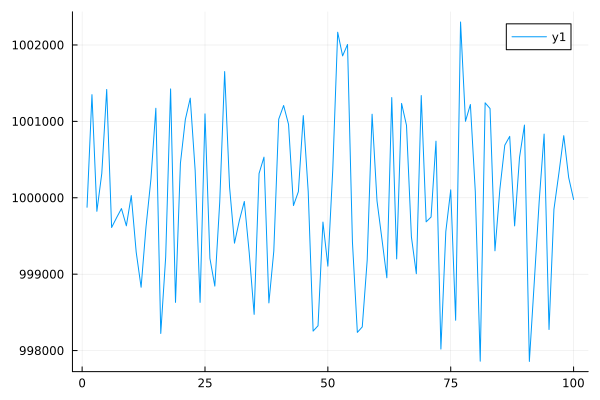

In [30]:
plot(d)

In [31]:
function get_d_threads!(d,x, J, L)
    Threads.@threads for i in 1:length(x)
        j = get_j(i, J, L, x)
        d[j] += 1
    end
end

get_d_threads! (generic function with 1 method)

In [32]:
dtf = zeros(J)

get_d_threads!(dtf,x, J, L)

dtf

100-element Vector{Float64}:
 997755.0
 998700.0
 997223.0
 998202.0
 999188.0
 997481.0
 997575.0
 997686.0
 996685.0
 997507.0
      ⋮
 996393.0
 997506.0
 998212.0
 995818.0
 997148.0
 997027.0
 998329.0
 997676.0
 997405.0

In [33]:
dtf === d

false

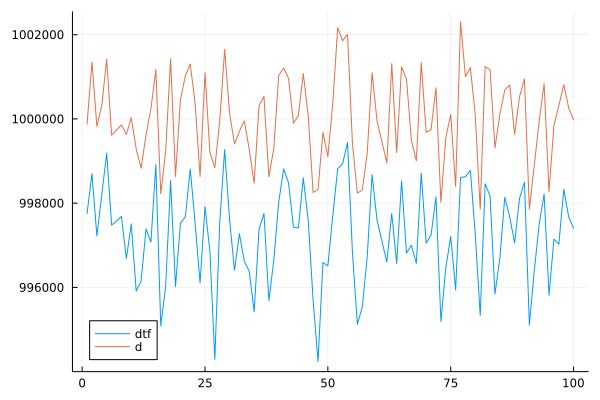

In [34]:
plot(dtf, label="dtf")
plot!(d, label="d")

In [35]:
function get_d_threads_good!(d,x, J, L)
    local_d = zeros(J, nthreads())
    @threads for i in 1:length(x)
        j = get_j(i, J, L, x)
        local_d[j,threadid()] += 1
    end
    d[:] = reduce(+, eachslice(local_d, dims=2))
end

get_d_threads_good! (generic function with 1 method)

In [38]:
dtg = zeros(J)
@btime get_d_threads_good!(dtg,x, J, L)

  3.441 s (19 allocations: 3.84 KiB)


100-element Vector{Float64}:
 999876.0
      1.00135e6
 999823.0
      1.000318e6
      1.001418e6
 999611.0
 999738.0
 999859.0
 999633.0
      1.000029e6
      ⋮
 998897.0
 999955.0
      1.000834e6
 998276.0
 999849.0
      1.000318e6
      1.000813e6
      1.000265e6
 999978.0

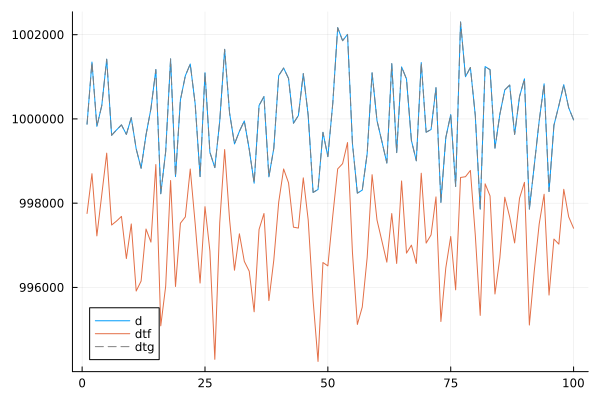

In [37]:
plot(d, label="d")
plot!(dtf, label="dtf")
plot!(dtg, label="dtg", ls=:dash, color="gray")

In [39]:
@btime get_d_threads!(dtf,x, J, L)

  3.407 s (15 allocations: 1.12 KiB)


In [40]:
@btime get_d!(d,x,J,L)

  6.092 s (0 allocations: 0 bytes)
